In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

from skzeros import AAA, Rectangle, find_zeros, force_subdivide, poles_residues
from skzeros._domain import get_leaf_regions

plt.style.use("style.mplstyle")

In [2]:
# https://discourse.julialang.org/t/computing-the-adjugate-cofactors-of-a-matrix/125184
def adjugate(A):
    U, S, VH = np.linalg.svd(A)
    phase_det = np.linalg.det(VH @ U)
    return VH.T.conj() @ (_adjugate_diagonal(S) * phase_det) @ U.conj().T


def _adjugate_diagonal(d):
    n = len(d)
    if n < 2:
        return np.diag(np.ones_like(d))

    dadj = np.empty_like(d)
    prefix = 1
    for i in range(n):
        dadj[i] = prefix
        prefix *= d[i]

    suffix = 1
    for i in reversed(range(n)):
        dadj[i] *= suffix
        suffix *= d[i]

    return np.diag(dadj)

In [3]:
rng = np.random.default_rng(1212)
n = 50
x = -0.4 + 0.8 * rng.integers(0, 1, n, endpoint=True)
A = scipy.linalg.circulant(x)

In [4]:
e = np.linalg.eigvals(A)

In [5]:
@np.vectorize
def f_1(z):
    return np.linalg.det(A - z * np.eye(n))


@np.vectorize
def f_1_z(z):
    return -np.trace(adjugate(A - z * np.eye(n)))

In [69]:
d = Rectangle(complex(-5.1, -4.9), complex(5, 4.7))
r = find_zeros(d, f_1, f_1_z, 7.1)

Beginning Subdivision
len(queue)=1
arg_principle.integral=np.complex128(50.00000000000006-3.413795358104175e-14j) REJECTED
len(queue)=2
arg_principle.integral=np.complex128(27.00000000000002+4.806171518655981e-15j) REJECTED
len(queue)=3
arg_principle.integral=np.complex128(23.000000000000004+1.668024232945311e-14j) REJECTED
len(queue)=4
arg_principle.integral=np.complex128(13.000000000000034-9.04691109394067e-15j) REJECTED
len(queue)=5
arg_principle.integral=np.complex128(14.000000000000009+1.1308638867425838e-15j) REJECTED
len(queue)=6
arg_principle.integral=np.complex128(11.000000000000004+1.3004934697539713e-14j) REJECTED
len(queue)=7
arg_principle.integral=np.complex128(12.000000000000021-3.392591660227751e-15j) REJECTED
len(queue)=8
arg_principle.integral=np.complex128(5.000000000000015-2.2617277734851675e-15j) ACCEPTED
len(queue)=7
arg_principle.integral=np.complex128(7.9999999999999885-9.04691109394067e-15j) REJECTED
len(queue)=8
arg_principle.integral=np.complex128(5.0000000000

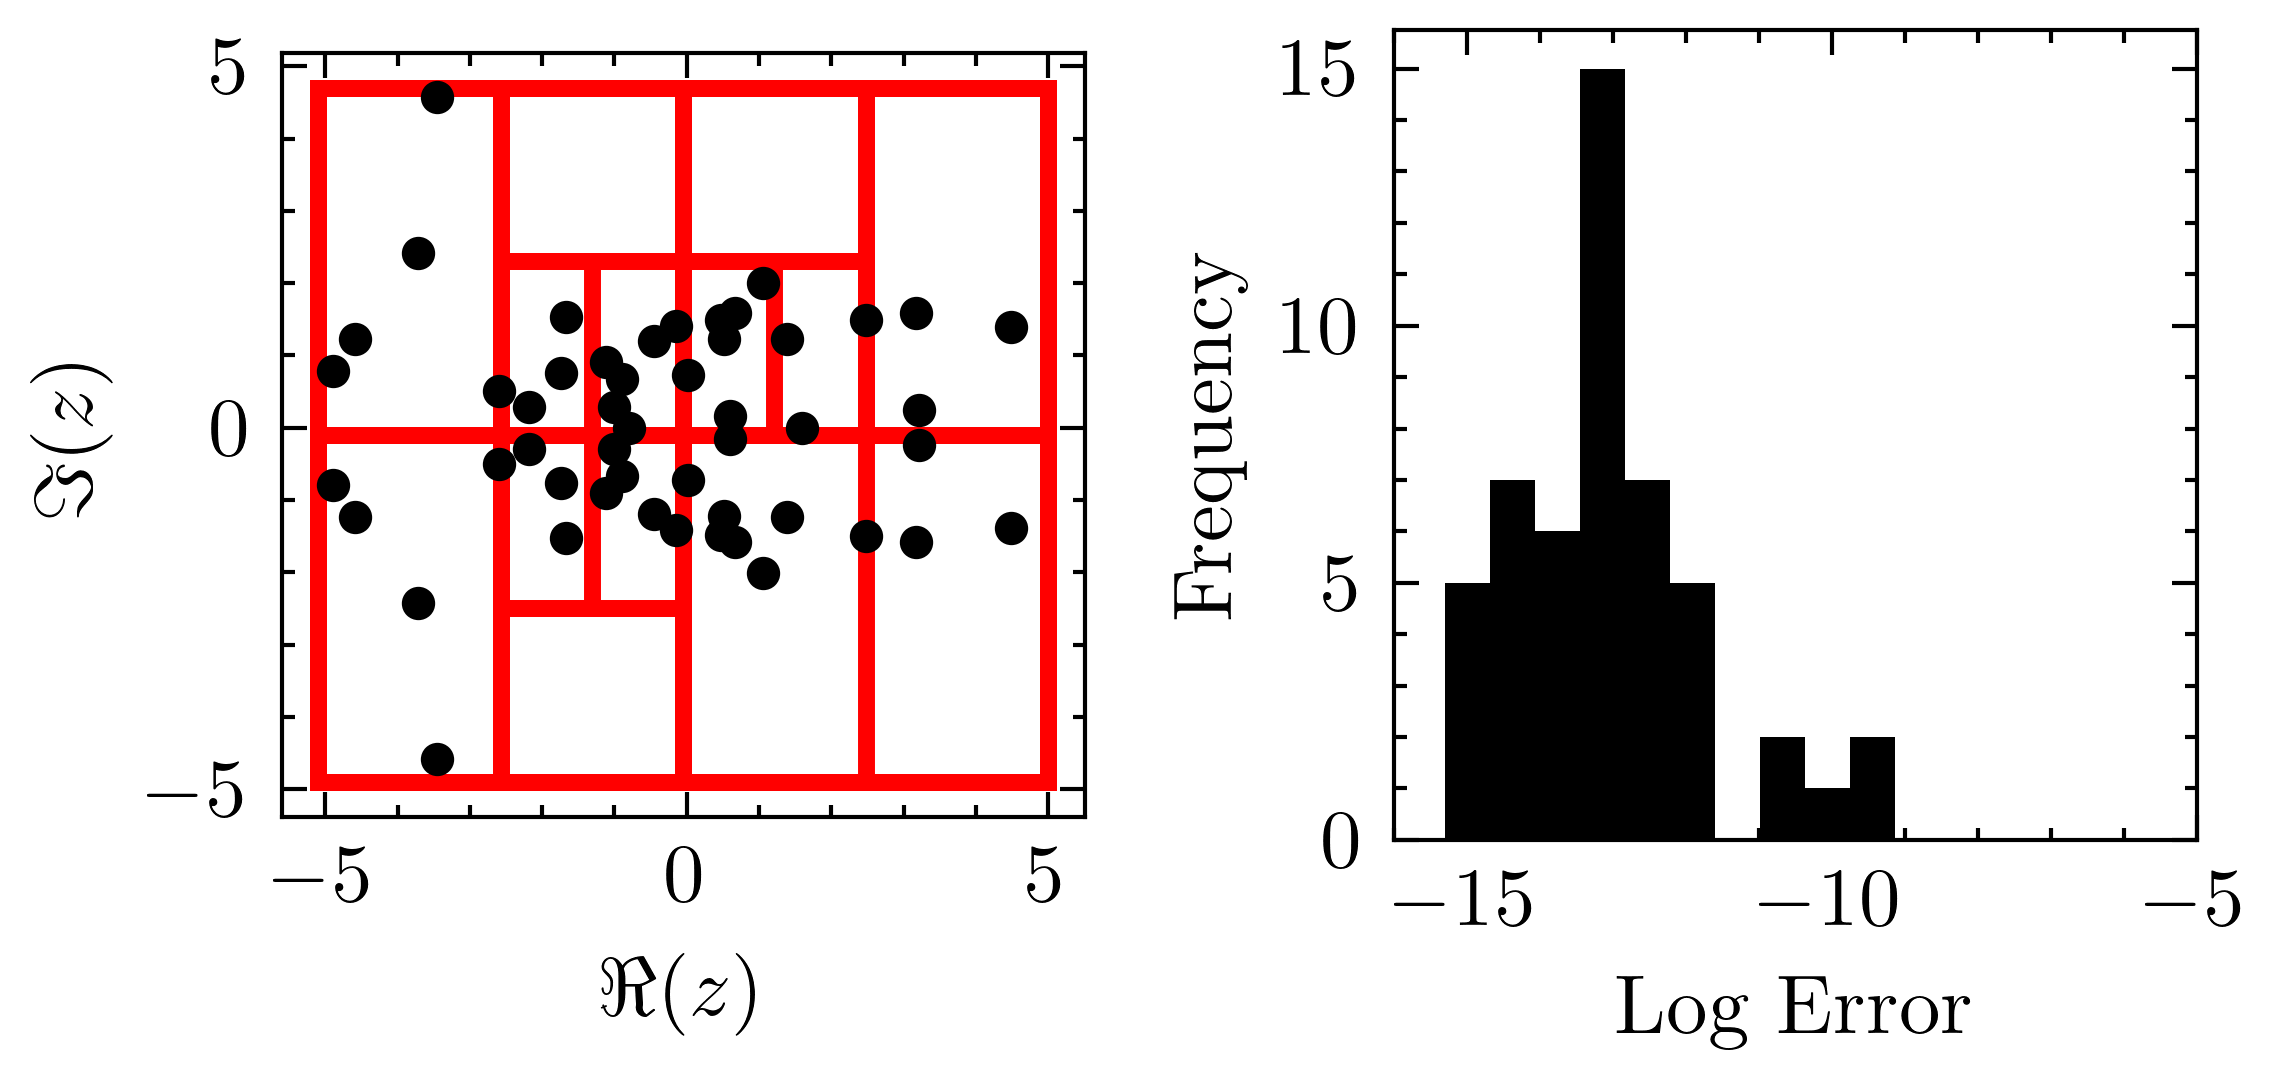

In [70]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(4, 2))
d.plot(ax1)
ax1.plot(r.zeros.real, r.zeros.imag, ".")
ax1.set_xlabel(r"$\Re(z)$")
ax1.set_ylabel(r"$\Im(z)$")
ax1.set_aspect("equal", "box")
ax2.hist(np.log10(np.min(np.abs(np.subtract.outer(e, r.zeros)), axis=-1)))
ax2.set_xlim([-16, -5])
ax2.set_xlabel("Log Error")
ax2.set_ylabel("Frequency")
plt.tight_layout()
plt.savefig("figures/example3a.pdf")

In [101]:
rng = np.random.default_rng(122144241122)
u, v = rng.random((2, n))


@np.vectorize
def f_2(z):
    return u.T @ scipy.linalg.solve(A - z * np.eye(n), v)


@np.vectorize
def f_2_z(z):
    return u.T @ scipy.linalg.solve(
        A - z * np.eye(n), scipy.linalg.solve(A - z * np.eye(n), v)
    )

In [109]:
d = Rectangle(complex(-5.1, -4.9), complex(5, 4.7))
force_subdivide(d, 6)
regions = get_leaf_regions(d)
poles = np.array([])
for region in tqdm(regions):
    res = AAA(lambda z: f_2_z(z) / f_2(z), region)
    p, r = poles_residues(*res, residue=True)
    bl, tr = region.bottom_left, region.top_right
    to_keep = (
        (p.real >= bl.real)
        & (p.real <= tr.real)
        & (p.imag >= bl.imag)
        & (p.imag <= tr.imag)
        & (r < 0)
        & (abs(r.real - np.round(r.real)) < 1e-3)
    )
    poles = np.concatenate((poles, p[to_keep]))

100%|██████████| 64/64 [00:21<00:00,  2.93it/s]


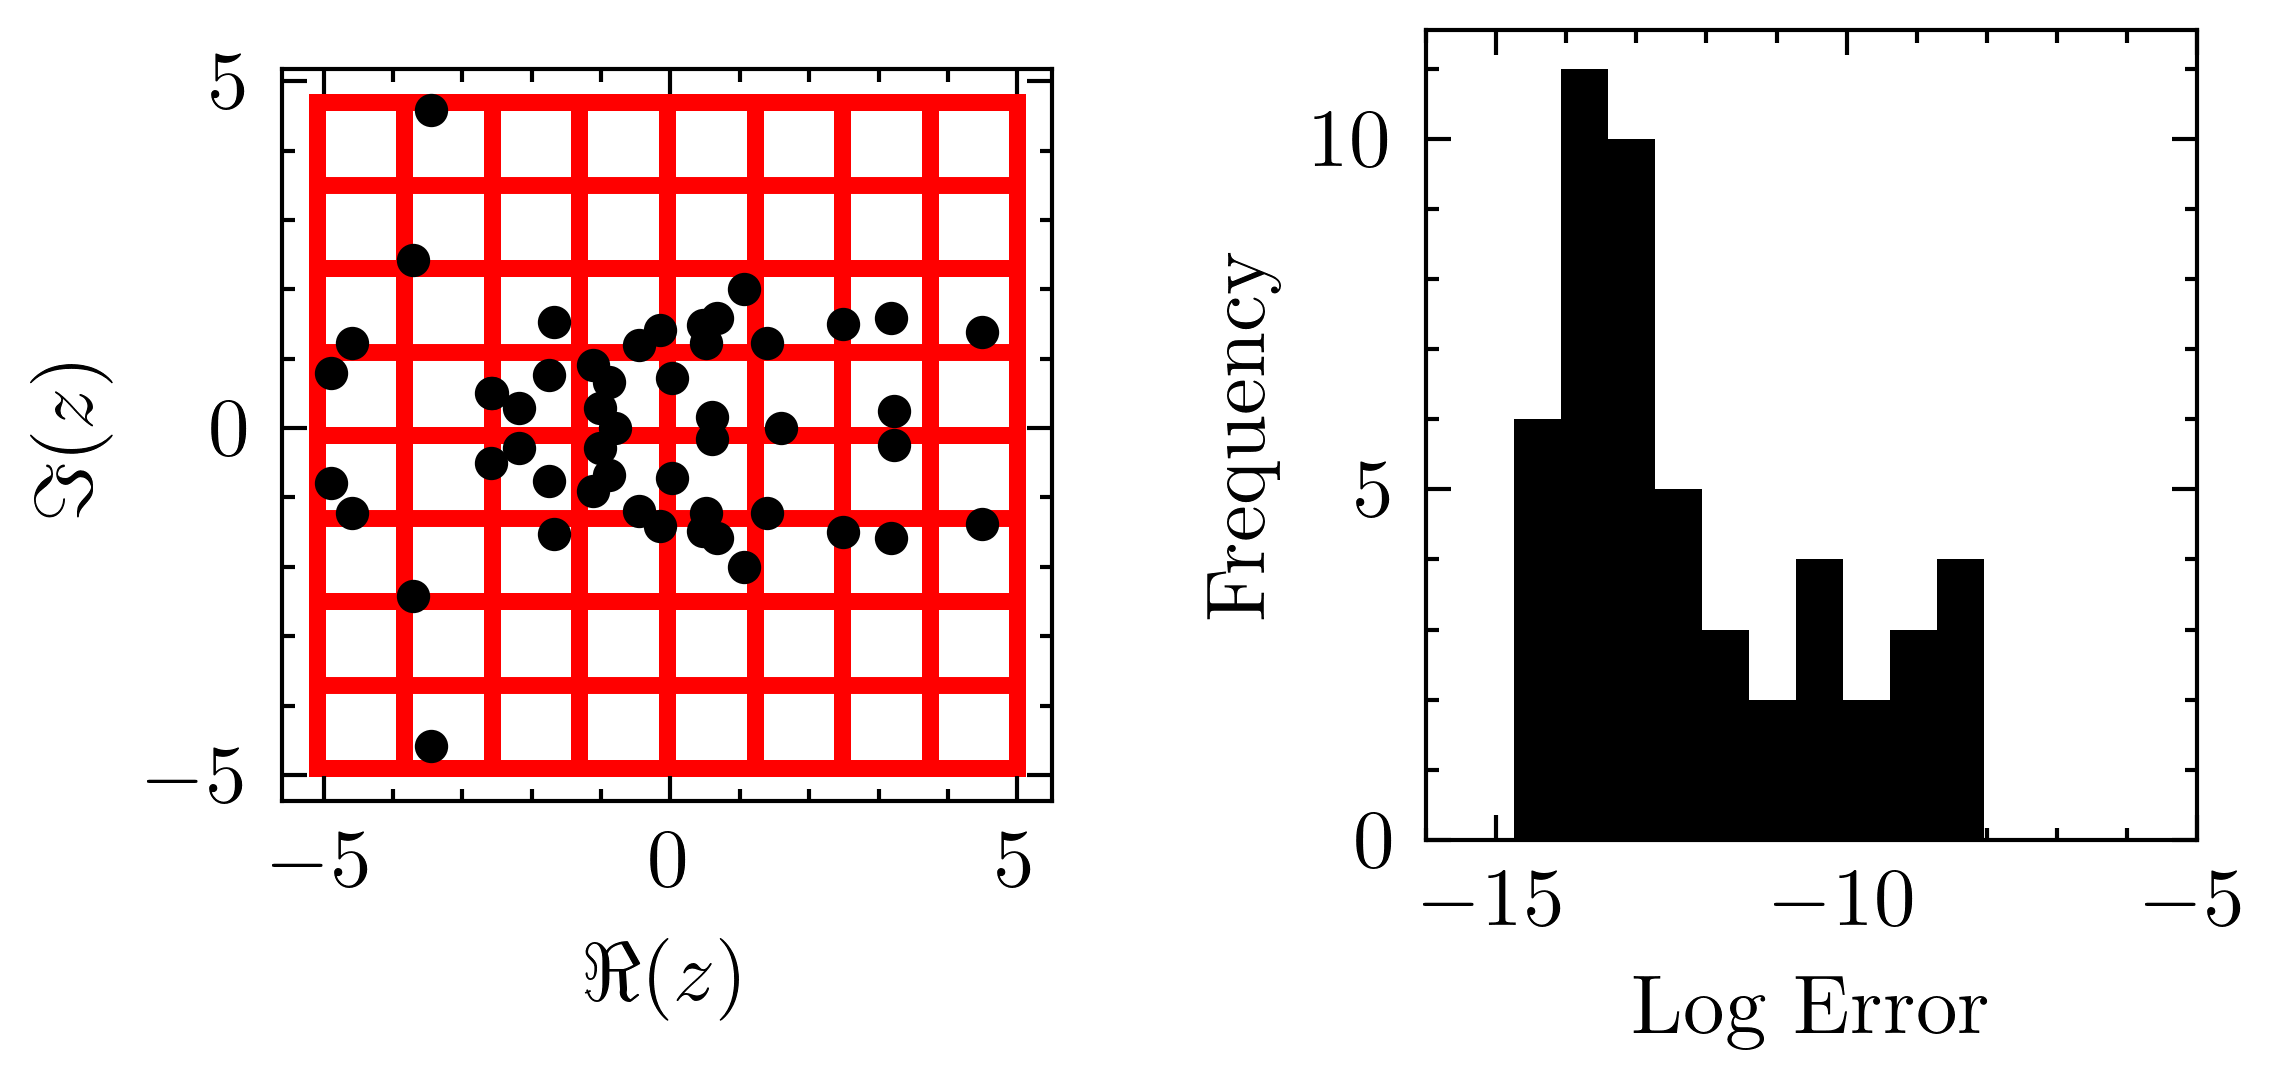

In [110]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(4, 2))
d.plot(ax1)
ax1.plot(poles.real, poles.imag, ".")
ax1.set_xlabel(r"$\Re(z)$")
ax1.set_ylabel(r"$\Im(z)$")
ax1.set_aspect("equal", "box")
ax2.hist(np.log10(np.min(np.abs(np.subtract.outer(e, poles)), axis=-1)))
ax2.set_xlim([-16, -5])
ax2.set_xlabel("Log Error")
ax2.set_ylabel("Frequency")
plt.tight_layout()
plt.savefig("figures/example3b.pdf")